# 02 - Preprocessing
Goal:
- Convert Order Date to datetime
- Aggregate sales to daily totals
- Create continuous daily timeseries and handle missing days
- Save processed CSVs: daily, weekly, monthly


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths (notebook is in notebooks/)
RAW_PATH = "../data/raw/train.csv"
PROCESSED_DIR = "../data/processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)


In [3]:
# load
df = pd.read_csv(RAW_PATH)

# quick check
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Sample rows:")
display(df[['Order Date','Ship Date','Sales']].head())


Shape: (9800, 18)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales']
Sample rows:


,Order Date,Ship Date,Sales
0,08/11/2017,11/11/2017,261.9600
1,08/11/2017,11/11/2017,731.9400
2,12/06/2017,16/06/2017,14.6200
3,11/10/2016,18/10/2016,957.5775
4,11/10/2016,18/10/2016,22.3680


In [5]:
# Convert Order Date -> datetime
# The dataset uses dd/mm/yyyy format (e.g. 08/11/2017), so use dayfirst=True
df['order_date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')

# Check for rows where conversion failed (should be none)
bad_dates = df['order_date'].isna().sum()
print("Failed to parse Order Date:", bad_dates)

# drop rows with no order_date (if any)
df = df.dropna(subset=['order_date']).copy()


Failed to parse Order Date: 0


In [7]:
# Aggregate: sum of Sales per day
daily = df.groupby('order_date')['Sales'].sum().sort_index().rename("sales")

# Quick peek
display(daily.head())
print("Date range:", daily.index.min(), "to", daily.index.max())
print("Number of unique days:", len(daily))


order_date
2015-01-03      16.448
2015-01-04     288.060
2015-01-05      19.536
2015-01-06    4407.100
2015-01-07      87.158
Name: sales, dtype: float64

Date range: 2015-01-03 00:00:00 to 2018-12-30 00:00:00
Number of unique days: 1230


In [11]:
# Make continuous daily index (so days with zero orders are explicit)
daily = daily.asfreq('D')  # reindex to daily frequency

# Option A (recommended for sales totals): fill missing days with 0 (no orders)
daily_zero = daily.fillna(0)

# Option B (if you prefer smoothing / interpolation): forward-fill then linear interpolate
# Replaced deprecated fillna(method='ffill') with ffill()
daily_ffill = daily.ffill().interpolate()

# Choose one to save — recommended: explicit zeros for retail sales
sales_daily = daily_zero

# Quick stats
print("Total days after reindex:", len(sales_daily))
sales_daily.head(10)


Total days after reindex: 1458


order_date
2015-01-03      16.448
2015-01-04     288.060
2015-01-05      19.536
2015-01-06    4407.100
2015-01-07      87.158
2015-01-08       0.000
2015-01-09      40.544
2015-01-10      54.830
2015-01-11       9.940
2015-01-12       0.000
Freq: D, Name: sales, dtype: float64

In [15]:
# Save daily
daily_csv = "../data/processed/sales_daily.csv"
sales_daily.to_csv(daily_csv, header=True)
print("Saved:", daily_csv)

# Weekly (sum by week - ending Sunday by default). You can also use 'W-MON' if weeks should end on Monday
sales_weekly = sales_daily.resample('W').sum()
sales_weekly.to_csv("../data/processed/sales_weekly.csv", header=True)

# Monthly (use 'ME' for month end instead of deprecated 'M')
sales_monthly = sales_daily.resample('ME').sum()
sales_monthly.to_csv("../data/processed/sales_monthly.csv", header=True)

print("Saved weekly & monthly aggregates too.")


Saved: ../data/processed/sales_daily.csv
Saved weekly & monthly aggregates too.


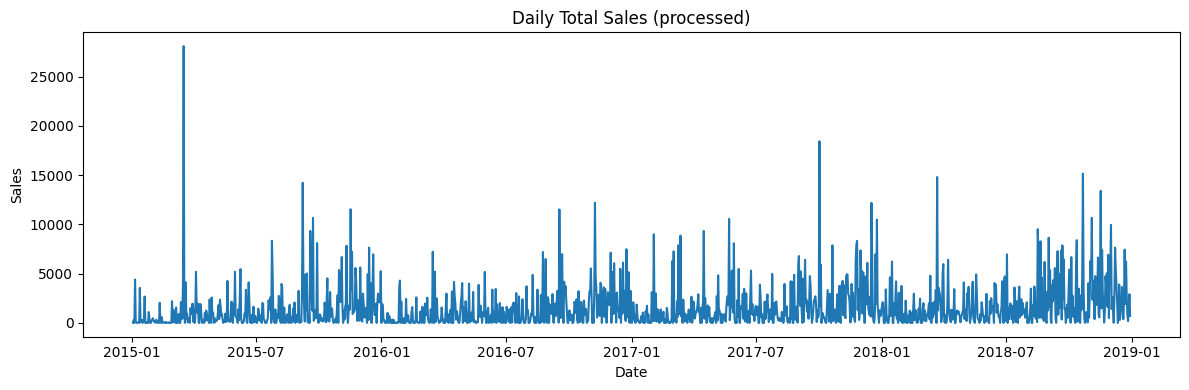

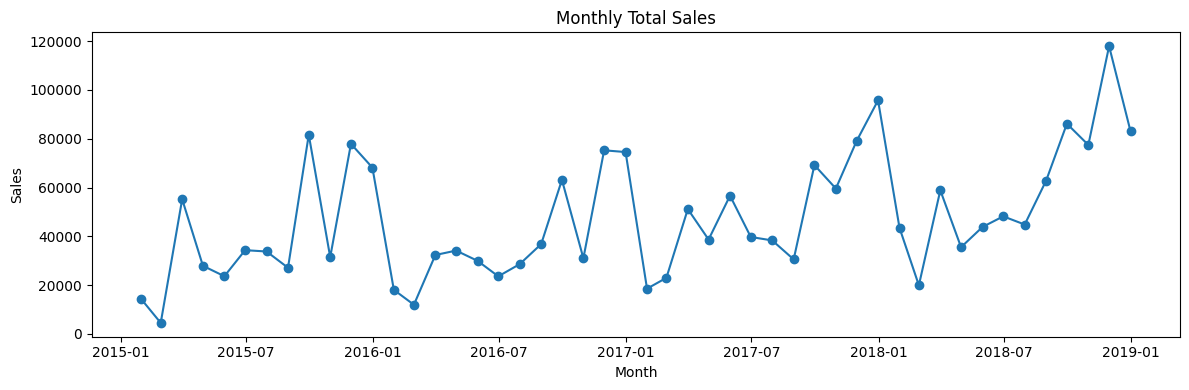

In [17]:
plt.figure(figsize=(12,4))
plt.plot(sales_daily.index, sales_daily.values)
plt.title("Daily Total Sales (processed)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(sales_monthly.index, sales_monthly.values, marker='o')
plt.title("Monthly Total Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


In [19]:
# If you don't want to push the full data to GitHub, save a small sample snapshot
sample_path = os.path.join(PROCESSED_DIR, "sales_daily_sample.csv")
sales_daily.reset_index().head(180).to_csv(sample_path, index=False)  # e.g., first 6 months
print("Saved sample to", sample_path)


Saved sample to ../data/processed\sales_daily_sample.csv
